In [3]:
import os
import tensorflow as tf
import cv2
import shutil
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
from tensorflow.keras.optimizers import RMSprop, SGD
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sn
from collections import Counter

In [ ]:
#import shutil

#shutil.rmtree('./tumor-datasplited')

In [ ]:
#input_folder = "./tumor-dataset"

#splitfolders.ratio(input_folder, output="tumor-datasplited", seed=42, ratio=(.7,.2,.1), group_prefix=None)


In [ ]:
try:
    #shutil.rmtree('./tumor-datasplited/.ipynb_checkpoints')
    shutil.rmtree('./tumor-datasplited/test/.ipynb_checkpoints')
    shutil.rmtree('./tumor-datasplited/train/.ipynb_checkpoints')
    shutil.rmtree('./tumor-datasplited/val/.ipynb_checkpoints')
except:
    pass

In [4]:
#testar brightness range, mudança de canal

train_data = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',)
traindata = train_data.flow_from_directory(directory="./tumor-datasplited/train",target_size=(224,224), class_mode='categorical')

val_data = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',)
valdata = val_data.flow_from_directory(directory="./tumor-datasplited/val",target_size=(224,224), class_mode='categorical')

test_data = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',)
testdata = test_data.flow_from_directory(directory="./tumor-datasplited/test",target_size=(224,224), class_mode='categorical', shuffle=False)

Found 2123 images belonging to 3 classes.
Found 606 images belonging to 3 classes.
Found 318 images belonging to 3 classes.


In [ ]:
"""counterT = Counter(traindata.classes)
print(counterT.items())
counterV = Counter(valdata.classes)
print(counterV.items())
counterTS = Counter(testdata.classes)
print(counterTS.items())


import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.50
fig, ax = plt.subplots(figsize =(12, 8))
 
# set height of bar
pTrain = [976, 279, 140]
pTest = [495, 141, 72]
pVal = [651, 186, 93]
 
    
number = [976,651,495, 279, 186, 141, 140, 93, 72]
    
br1 = np.arange(len(pTrain))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, pTrain, color ='#52baa7', width = barWidth,
        edgecolor ='grey', label ='glioma')
plt.bar(br2, pVal, color ='#718f85', width = barWidth,
        edgecolor ='grey', label ='meningioma')
plt.bar(br3, pTest, color ='#ba5252', width = barWidth,
        edgecolor ='grey', label ='pituitary')

plt.xlabel('Base de dados', fontweight ='bold', fontsize = 10)
plt.ylabel('Quantidade', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(len(pTrain))],
        ['Treinamento', 'Validacao', 'Teste'])
 
plt.legend()
plt.show()"""

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=3)


for layers in base_model.layers:
    layers.trainable=True

In [ ]:
resnet50_x = Flatten()(base_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(3,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=base_model.input, outputs=resnet50_x)

In [ ]:
model = resnet50_x_final_model
model.compile(loss='categorical_crossentropy', optimizer = SGD(lr=0.0001, momentum=0.9),metrics=['accuracy'])
model.summary()

In [ ]:
checkpoint = ModelCheckpoint("ResNet50.h5", monitor='val_accuracy', 
                             verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')



In [ ]:
batch_size = 32

hist = model.fit_generator(steps_per_epoch=(traindata.n//batch_size),generator=traindata, validation_data= valdata, validation_steps=(valdata.n//batch_size),epochs=100,callbacks=[checkpoint, early])

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Acuracia de treinamento')
plt.plot(epochs, val_acc, label='Acuracia de validacao')
plt.title('Acuracia de treinamento e validacao')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Perda de treinamento')
plt.plot(epochs, val_loss, label='Perda de validacao')
plt.title('Perda de validacao e treinamento')
plt.legend()

Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ['glioma', 'meningioma', 'pituitary']],
                  columns = [i for i in ['glioma', 'meningioma', 'pituitary']])
plt.figure(figsize = (10,7))


sn.heatmap(df_cm, annot=True, cmap="Reds")
print('Classification Report')
target_names = ['glioma', 'meningioma', 'pituitary']
print(classification_report(testdata.classes, y_pred, target_names=target_names))
plt.show()

In [1]:
from tensorflow import keras
model = keras.models.load_model('./ResNet50.h5')

2022-12-06 13:56:02.936868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 13:56:02.945914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 13:56:02.946162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 13:56:02.946837: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

[[9.99999881e-01 1.78725017e-07 3.12992610e-09]
 [9.71656203e-01 2.82550585e-02 8.86708222e-05]
 [9.99996066e-01 1.85711815e-06 1.97295367e-06]
 [9.99814093e-01 1.85974146e-04 4.63480845e-08]
 [1.00000000e+00 4.14875139e-08 1.52831289e-10]
 [9.98971105e-01 1.02521700e-03 3.65223377e-06]
 [1.00000000e+00 3.74579763e-08 5.79685953e-08]
 [9.99999881e-01 1.65915864e-07 5.37389022e-09]
 [1.00000000e+00 6.34885478e-11 8.48742084e-13]
 [1.00000000e+00 1.65823327e-11 1.00325970e-14]
 [9.89233732e-01 1.07367598e-02 2.94570418e-05]
 [9.98426437e-01 1.56759203e-03 5.98900897e-06]
 [9.99997258e-01 2.67566907e-06 8.04859681e-08]
 [7.09514141e-01 2.90265203e-01 2.20652320e-04]
 [9.99998569e-01 1.45039655e-06 1.30692734e-09]
 [5.50684392e-01 3.15948337e-01 1.33367285e-01]
 [1.00000000e+00 3.28035377e-09 4.54931115e-09]
 [9.99991775e-01 7.99622921e-06 2.36531903e-07]
 [9.99157548e-01 8.40860826e-04 1.57783074e-06]
 [9.98580813e-01 9.67051717e-04 4.52067354e-04]
 [9.64317083e-01 3.56267169e-02 5.620328

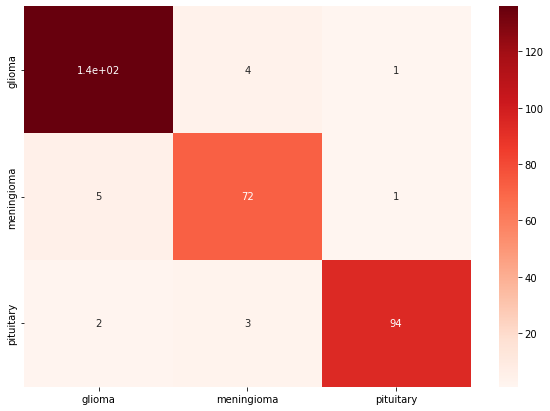

In [6]:
import matplotlib.pyplot as plt

Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testdata.classes, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ['glioma', 'meningioma', 'pituitary']],
                  columns = [i for i in ['glioma', 'meningioma', 'pituitary']])
plt.figure(figsize = (10,7))

print(Y_pred)

sn.heatmap(df_cm, annot=True, cmap="Reds")
print('Classification Report')
target_names = ['glioma', 'meningioma', 'pituitary']
print(classification_report(testdata.classes, y_pred, target_names=target_names))

plt.show()